# CoLA with HaGraD, backed by  <img src="https://upload.wikimedia.org/wikipedia/commons/1/10/PyTorch_logo_icon.svg" style="height:0.75em"/>PyTorch

---

Guidance by this [notebook by bentrevett](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb). Network foloowing [Warstadt et a. (2019)](https://arxiv.org/pdf/1805.12471.pdf).

### Setup

In [446]:
## Stuff from torch
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url

## Stuff from torchtext
import torchtext as tt
from torchtext.datasets import CoLA
from torchtext.data import get_tokenizer
import torchtext.functional as ttF
import torchtext.vocab as ttv

## Misc
import numpy as np
import string

## Additional stuff
import matplotlib.pyplot as plt
import sys
if "..\\" not in sys.path: sys.path.append("..\\")
from src.torch_hagrad import Hagrad

---

### Data Preprocessing

In [447]:
trn_rawpipe = CoLA(split="train").shuffle()
tst_rawpipe = CoLA(split= "test").shuffle()

In [448]:
## Preprocessor
tokenizer = get_tokenizer("basic_english")
def tokenize(x):
    text = "".join([char for char in x[2] if char not in string.punctuation])
    text = tokenizer(text)
    return text, x[1]

## Vocab Iterator
def yield_tokens(text_datapipe):
    for x in text_datapipe:
        yield x[0]

In [449]:
## Preprocessing Data
trn_tokenpipe = trn_rawpipe.map(tokenize)
tst_tokenpipe = tst_rawpipe.map(tokenize)

In [450]:
## Constructing Vocab (using train data)
#  Saving time when rerunning the notebook...
if 'vocab' not in locals():
    vocab = ttv.build_vocab_from_iterator(
        yield_tokens(trn_tokenpipe), specials=["<unk>"], max_tokens=5000)
    vocab.set_default_index(0)

### Finalize <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">DataLoaders</span>

In [451]:
batch_size = 128

# Transform the raw dataset using non-batched API (i.e apply transformation line by line)
def vocab_lookup(x):
    return vocab.lookup_indices(x[0]), x[1]

trn_datapipe = (trn_tokenpipe.map(vocab_lookup)
                             .batch(batch_size)
                             .rows2columnar(["token_ids", "target"]))
trn_dataloader = DataLoader(trn_datapipe, batch_size=None)

tst_datapipe = (tst_tokenpipe.map(vocab_lookup)
                             .batch(batch_size)
                             .rows2columnar(["token_ids", "target"]))
tst_dataloader = DataLoader(tst_datapipe, batch_size=None)

___

### Define Model

In [452]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


In [453]:
padding_idx = 0
num_classes = 2
vocab_size = len(vocab)
embedding_size = 32
rnn_hidden_size = 32
rnn_layers = 2
linear_size = 64
dropout = 0.3

The model is only used for illustration purposes (HaGraD implementation works). The architechture is to simple and the dataset is to small. In the [original publication](https://arxiv.org/pdf/1805.12471.pdf) the authors use pretrained embeddings (like ELMo, GloVe etcl.) to actually enable noticeable performance. If you still believe the optimizer is to blame, feel free du uncomment the <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">Adam</span> line below and try it youself.

In [454]:
class BidirLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding  = nn.Embedding(vocab_size, embedding_size, 
                                       padding_idx=padding_idx)
        self.rnn        = nn.LSTM(embedding_size, rnn_hidden_size, 
                                  num_layers=rnn_layers, batch_first=True, 
                                  bidirectional=True, dropout=dropout
                                  )
        self.dense      = nn.Sequential(
            nn.Linear(2*rnn_hidden_size, linear_size),
            nn.Sigmoid())
        self.out        = nn.Linear(linear_size, 1)
        self.dropout    = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, rnn_hidden = self.rnn(x)
        x = self.dense(rnn_out[:, -1, :])
        x = self.dropout(x)
        x = self.out(x).flatten()
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = BidirLSTM().to(device)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 78,977 trainable parameters


### "Compiling" the Model

In [455]:
optimizer = Hagrad(model.parameters(), epsilon=0.05, gamma=10., p_mean=0.)
# optimizer = torch.optim.Adam(model.parameters(), 1e-4) # Uncomment this line to try e. g. Adam.
loss_fn = nn.BCEWithLogitsLoss()
loss_fn = loss_fn.to(device)

### Acutal Training:

In [456]:
def train(input, target, return_loss=True):
    model.train()
    output = model(input)
    loss = loss_fn(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if return_loss:
        return loss.detach().cpu().numpy()

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.sum()

def eval_step(input, target):
    output = model(input)
    loss = loss_fn(output, target).item()
    return float(loss), binary_accuracy(output, target)

def evaluate():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():
        for batch in tst_dataloader:
            input = (ttF.to_tensor(batch["token_ids"], padding_value=padding_idx)
                        .to(device))
            target = torch.tensor(batch["target"], dtype=torch.float32).to(device)
            loss, predictions = eval_step(input, target)
            total_loss += loss
            correct_predictions += predictions
            total_predictions += len(target)
            counter += 1

    return total_loss / counter, correct_predictions / total_predictions

In [457]:
loss_history = []
val_loss_history = []

num_epochs = 10

for e in range(num_epochs):
    for i, batch in enumerate(trn_dataloader):
        input = (ttF.to_tensor(batch["token_ids"], padding_value=padding_idx)
                    .to(device))
        target = torch.tensor(batch["target"], dtype=torch.float32).to(device)
        loss_detached = train(input, target)
        loss_history.append(loss_detached)
        print(f"Batch = [{i}], loss = [{loss_history[-1]:.2f}]", end="\r")

    loss, accuracy = evaluate()
    print(f"Epoch = [{e+1}], loss = [{loss:.2f}], accuracy = [{accuracy:.2f}]")
    val_loss_history.append(loss)

Epoch = [1], loss = [0.63], accuracy = [0.69]
Epoch = [2], loss = [0.63], accuracy = [0.69]
Epoch = [3], loss = [0.68], accuracy = [0.69]
Epoch = [4], loss = [0.57], accuracy = [0.69]
Epoch = [5], loss = [0.63], accuracy = [0.69]
Epoch = [6], loss = [0.63], accuracy = [0.69]
Epoch = [7], loss = [0.68], accuracy = [0.69]
Epoch = [8], loss = [0.63], accuracy = [0.69]
Epoch = [9], loss = [0.57], accuracy = [0.69]
Epoch = [10], loss = [0.63], accuracy = [0.69]


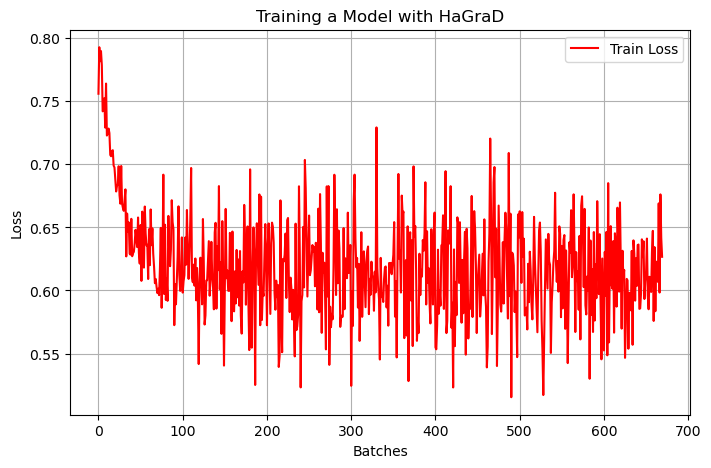

In [458]:
fig = plt.figure(figsize=(8, 5))
plt.plot(loss_history, "-r", label="Train Loss")
plt.legend()
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.grid()
plt.title("Training a Model with HaGraD")
plt.show()

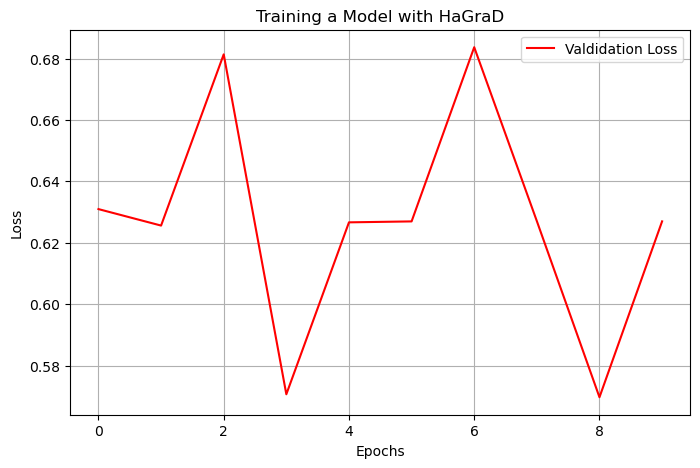

In [459]:
fig = plt.figure(figsize=(8, 5))
plt.plot(val_loss_history, "-r", label="Valdidation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.title("Training a Model with HaGraD")
plt.show()